## Exploring (flat) rats

**June 2018**. As part of the Optoro data team's hack day, I took a look at [codefordc/the-rat-hack](https://github.com/codefordc/the-rat-hack) - specifically, the 2016 311 calls relating to rodents.

The majority of this notebook is just some initial exploratory data analysis, to get a sense of the frequency - for example - of rodent calls versus all 311 calls. I then started looking at time series models for predicting rodents (my prior is that it's very seasonal; more rats during hotter months?).

The data used in this notebook can be found [here](https://www.dropbox.com/sh/4j7q53lltasez3h/AADzLTkEys24HW_YLqrkWI5ia/single_year?dl=0&preview=dc_311-2016.csv).


In [220]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import statsmodels.tsa as ts
from matplotlib import pyplot as plt

plt.style.use('bmh')

mpl.rcParams['agg.path.chunksize'] = 10000
mpl.rcParams['figure.figsize'] = (12,8)

In [221]:
def df_shape(dataframe: pd.DataFrame) -> str:
    """Print the df shape nicely"""
    print(f'rows\t{dataframe.shape[0]:,.0f}')
    print(f'cols\t{dataframe.shape[1]:,.0f}')

In [222]:
df = pd.read_csv('data/single_year/dc_311-2016.csv')
print(df_shape(df))
df.head()

rows	499,111
cols	36
None


/Users/aambroz/.pyenv/versions/3.6.1/envs/global_optoro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SERVICEREQUESTID,SERVICEPRIORITY,SERVICECODE,SERVICECODEDESCRIPTION,SERVICETYPECODE,SERVICETYPECODEDESCRIPTION,SERVICEORDERDATE,SERVICEORDERSTATUS,SERVICECALLCOUNT,AGENCYABBREVIATION,...,WARD,ANC,SMD,DISTRICT,PSA,NEIGHBORHOODCLUSTER,HOTSPOT2006NAME,HOTSPOT2005NAME,HOTSPOT2004NAME,SERVICESOURCECODE
0,16-00777589,Standard,S0311,Rodent Inspection and Treatment,DEPAHEAL,DOH- Department Of Health,2016-10-29T15:09:22Z,Closed,1,DOH,...,5,5E,5E03,Fifth,502,21,NaN,NaN,NaN,PHONE
1,16-00784971,Standard,S0276,Parking Meter Repair,TRAOP001,Transportation Operations Administration,2016-11-02T17:51:20Z,Closed,1,DDOT,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHONE
2,16-00785648,Standard,S0276,Parking Meter Repair,TRAOP001,Transportation Operations Administration,2016-11-02T21:12:32Z,Closed,1,DDOT,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311-API
3,16-00778205,Standard,S04TP,Tree Planting,URBAFORR,Urban Forrestry,2016-10-31T03:32:41Z,In-Progress,1,DDOT,...,2,2F,2F01,Third,307,NaN,NaN,NaN,NaN,311-API
4,16-00785064,Standard,S0276,Parking Meter Repair,TRAOP001,Transportation Operations Administration,2016-11-02T18:12:54Z,Closed,1,DDOT,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311-API


In [218]:
(df['SERVICECODEDESCRIPTION'].value_counts() / len(df)).head()

DC Government Information            0.378880
Bulk Collection                      0.090918
Parking Meter Repair                 0.068245
Parking Enforcement                  0.066184
Emergency No-Parking Verification    0.025381
Name: SERVICECODEDESCRIPTION, dtype: float64

In [219]:
(df['SERVICECODEDESCRIPTION'].value_counts() / len(df)).tail()

FEMS - Fire Safety Education             0.000002
Citation                                 0.000002
School Transit Subsidy Program           0.000002
Emergency - Heating and Cooling          0.000002
General Environmental Concerns (DOEE)    0.000002
Name: SERVICECODEDESCRIPTION, dtype: float64

In [74]:
df[df['SERVICECODE']=='S0311']['SERVICECODEDESCRIPTION'].value_counts()

Rodent Inspection and Treatment    3516
Name: SERVICECODEDESCRIPTION, dtype: int64

In [75]:
rats = df[df['SERVICECODE']=='S0311']
print(df_shape(rats))
rats.head()

rows	3,516
cols	38
None


,SERVICEREQUESTID,SERVICEPRIORITY,SERVICECODE,SERVICECODEDESCRIPTION,SERVICETYPECODE,SERVICETYPECODEDESCRIPTION,SERVICEORDERDATE,SERVICEORDERSTATUS,SERVICECALLCOUNT,AGENCYABBREVIATION,...,SMD,DISTRICT,PSA,NEIGHBORHOODCLUSTER,HOTSPOT2006NAME,HOTSPOT2005NAME,HOTSPOT2004NAME,SERVICESOURCECODE,time_to_resolve,time_to_resolve_rolling
499019,16-00351629,Standard,S0311,Rodent Inspection and Treatment,DEPAHEAL,DOH- Department Of Health,2016-01-01 20:12:04,Open,1,DOH,...,6B04,First,107,26,NaN,NaN,NaN,WEB,NaN,NaN
499036,16-00351646,Standard,S0311,Rodent Inspection and Treatment,DEPAHEAL,DOH- Department Of Health,2016-01-01 21:40:15,Open,1,DOH,...,2B04,Third,301,NaN,NaN,NaN,NaN,311-API,NaN,NaN
498572,16-00351794,Standard,S0311,Rodent Inspection and Treatment,DEPAHEAL,DOH- Department Of Health,2016-01-02 16:00:20,Open,1,DOH,...,2D02,Second,208,1,NaN,NaN,NaN,PHONE,NaN,NaN
498641,16-00351863,Standard,S0311,Rodent Inspection and Treatment,DEPAHEAL,DOH- Department Of Health,2016-01-02 17:21:37,Open,1,DOH,...,1A01,Fourth,409,2,NaN,NaN,NaN,WEB,NaN,NaN
498796,16-00352018,Standard,S0311,Rodent Inspection and Treatment,DEPAHEAL,DOH- Department Of Health,2016-01-02 21:14:54,Open,1,DOH,...,1B06,Third,304,2,NaN,NaN,NaN,PHONE,NaN,NaN


So `S0311` is the service code for rats.

In [3]:
df.columns

Index(['SERVICEREQUESTID', 'SERVICEPRIORITY', 'SERVICECODE',
       'SERVICECODEDESCRIPTION', 'SERVICETYPECODE',
       'SERVICETYPECODEDESCRIPTION', 'SERVICEORDERDATE', 'SERVICEORDERSTATUS',
       'SERVICECALLCOUNT', 'AGENCYABBREVIATION', 'INSPECTIONFLAG',
       'INSPECTIONDATE', 'RESOLUTION', 'RESOLUTIONDATE', 'SERVICEDUEDATE',
       'SERVICENOTES', 'PARENTSERVICEREQUESTID', 'ADDDATE', 'LASTMODIFIEDDATE',
       'SITEADDRESS', 'LATITUDE', 'LONGITUDE', 'ZIPCODE',
       'MARADDRESSREPOSITORYID', 'DCSTATADDRESSKEY', 'DCSTATLOCATIONKEY',
       'WARD', 'ANC', 'SMD', 'DISTRICT', 'PSA', 'NEIGHBORHOODCLUSTER',
       'HOTSPOT2006NAME', 'HOTSPOT2005NAME', 'HOTSPOT2004NAME',
       'SERVICESOURCECODE'],
      dtype='object')

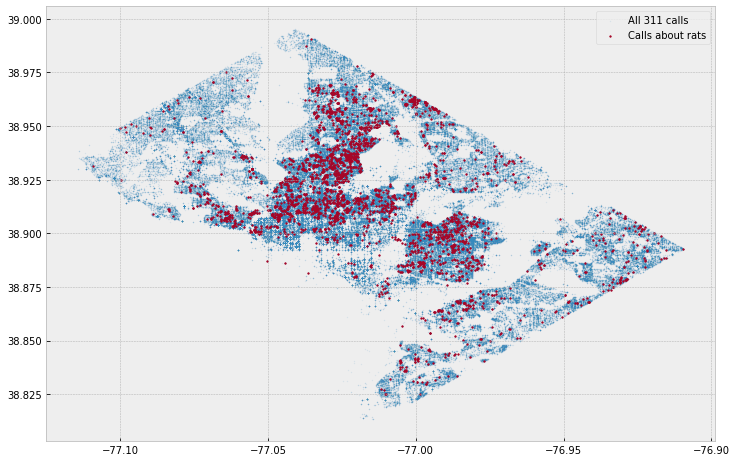

In [211]:
plt.scatter(df['LONGITUDE'], df['LATITUDE'], s=1, alpha=0.075, label='All 311 calls')
plt.scatter(rats['LONGITUDE'], rats['LATITUDE'], s=3, label='Calls about rats')
plt.legend()
plt.show()

In [80]:
date_cols = ['SERVICEORDERDATE', 'INSPECTIONDATE', 'RESOLUTIONDATE']
df[date_cols].head()

,SERVICEORDERDATE,INSPECTIONDATE,RESOLUTIONDATE
499075,2016-01-01 00:08:43,NaT,2016-01-01 00:08:43
499076,2016-01-01 00:18:19,NaT,2016-01-01 00:18:19
499077,2016-01-01 00:19:32,NaT,NaT
499078,2016-01-01 00:19:35,NaT,NaT
499079,2016-01-01 00:24:46,NaT,NaT


In [81]:
for col in date_cols:
    for data in [df, rats]:
        data[col] = pd.to_datetime(data[col])

/Users/aambroz/.pyenv/versions/3.6.1/envs/global_optoro/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
df.sort_values(by='SERVICEORDERDATE', inplace=True)
for data in [df, rats]:
    rats['time_to_resolve'] = (rats['RESOLUTIONDATE'] - rats['SERVICEORDERDATE']).dt.days

/Users/aambroz/.pyenv/versions/3.6.1/envs/global_optoro/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


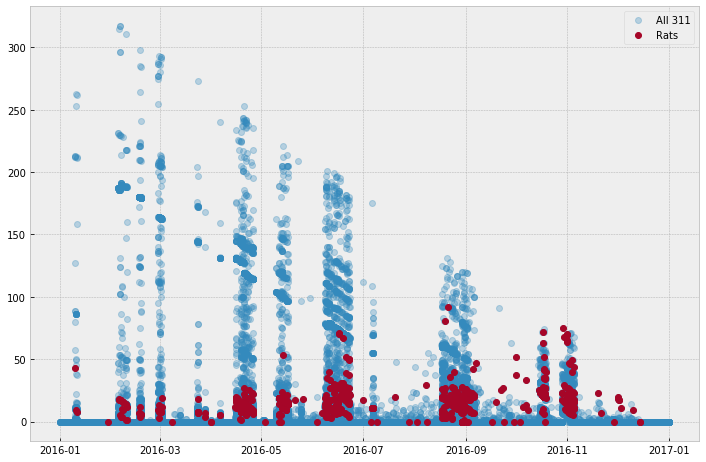

In [90]:
plt.plot(df['SERVICEORDERDATE'], df['time_to_resolve'], 'o', alpha=0.3, label='All 311')
plt.plot(rats['SERVICEORDERDATE'], rats['time_to_resolve'], 'o', label='Rats')
plt.legend()
plt.show()

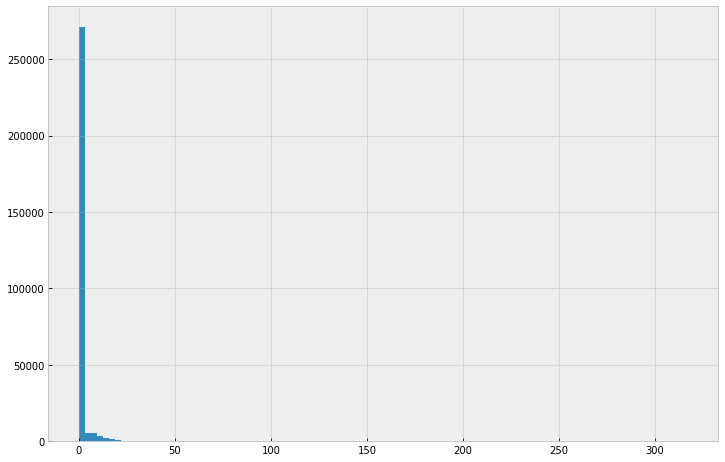

In [93]:
df['time_to_resolve'].hist(bins=100)
plt.show()

# Rats per day

In [101]:
df.head()

,SERVICEREQUESTID,SERVICEPRIORITY,SERVICECODE,SERVICECODEDESCRIPTION,SERVICETYPECODE,SERVICETYPECODEDESCRIPTION,SERVICEORDERDATE,SERVICEORDERSTATUS,SERVICECALLCOUNT,AGENCYABBREVIATION,...,SMD,DISTRICT,PSA,NEIGHBORHOODCLUSTER,HOTSPOT2006NAME,HOTSPOT2005NAME,HOTSPOT2004NAME,SERVICESOURCECODE,time_to_resolve,time_to_resolve_rolling
499075,16-00351510,Standard,DCGOVTINFO,DC Government Information,311CALCE,311- Call Center,2016-01-01 00:08:43,Closed,1,OUC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHONE,0.0,NaN
499076,16-00351511,Standard,DCGOVTINFO,DC Government Information,311CALCE,311- Call Center,2016-01-01 00:18:19,Closed,1,OUC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHONE,0.0,NaN
499077,16-00351512,Standard,PVDNUSIT,DYRS - Placement Violations,TRU311,Tru-311,2016-01-01 00:19:32,Open,1,OUC,...,7E05,Sixth,604,33,NaN,NaN,NaN,WEB,NaN,NaN
499078,16-00351513,Standard,PVDNUSIT,DYRS - Placement Violations,TRU311,Tru-311,2016-01-01 00:19:35,Open,1,OUC,...,7E05,Sixth,604,33,NaN,NaN,NaN,WEB,NaN,NaN
499079,16-00351514,Standard,S0031,Bulk Collection,SWMCOLBU,SWMA- Solid Waste Management Admistration,2016-01-01 00:24:46,Open,1,DPW,...,4C08,Fourth,407,18,NaN,NaN,NaN,WEB,NaN,NaN


In [181]:
df['date'] = df['SERVICEORDERDATE'].dt.date
rats['date'] = rats['SERVICEORDERDATE'].dt.date
days = df[['date', 'SERVICEREQUESTID']].groupby('date').count().rename(columns={'SERVICEREQUESTID': 'all'})
rat_days = rats[['date', 'SERVICEREQUESTID']].groupby('date').count().rename(columns={'SERVICEREQUESTID': 'rats'})
days = pd.merge(days, rat_days, left_index=True, right_index=True).reset_index()
days.head()

/Users/aambroz/.pyenv/versions/3.6.1/envs/global_optoro/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,date,all,rats
0,2016-01-01,150,2
1,2016-01-02,425,5
2,2016-01-04,931,3
3,2016-01-05,904,9
4,2016-01-06,899,6


In [182]:
days.sort_values(by='date', inplace=True)
days['rat_rate'] = days['rats'] / days['all']
days['rat_rate_rolling'] = days['rat_rate'].rolling(7).mean()

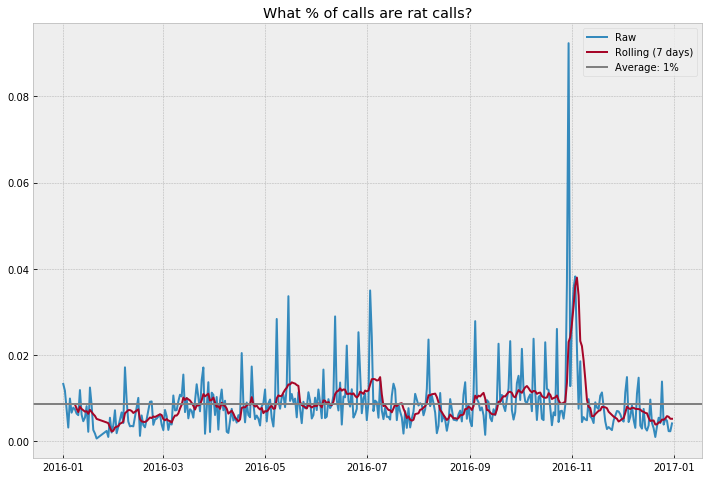

In [183]:
plt.plot(days['date'], days['rat_rate'], label='Raw')
plt.plot(days['date'], days['rat_rate_rolling'], label='Rolling (7 days)')
plt.axhline(days['rat_rate'].mean(), color='gray', label=f'Average: {days["rat_rate"].mean()*100:.0f}%')
plt.title('What % of calls are rat calls?')
plt.legend()
plt.show()

# Predicting rats 

`rats = f(season)`

Data:
`number of rat calls, number of total calls, date`

Time series?

In [144]:
days.head()

,date,all,rats,rat_rate,rat_rate_rolling
0,2016-01-01,150,2,0.013333,NaN
1,2016-01-02,425,5,0.011765,NaN
2,2016-01-04,931,3,0.003222,NaN
3,2016-01-05,904,9,0.009956,NaN
4,2016-01-06,899,6,0.006674,NaN


In [151]:
train = days[days['date'] < datetime(2016,8,1).date()][['rat_rate']].copy().as_matrix()
test = days[days['date'] >= datetime(2016,8,1).date()][['rat_rate']].copy().as_matrix()
train.shape, test.shape

((200, 1), (149, 1))

In [187]:
ar_model = ts.ar_model.AR(train)
ar_model_fitted = ar_model.fit()

# Forecasting
preds = ar_model_fitted.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
preds_df = pd.DataFrame(preds, index=days.iloc[-len(preds):].index).rename(columns={0: 'preds'})
preds_df.head()

,preds
200,0.008034
201,0.008018
202,0.008216
203,0.006895
204,0.006858


In [205]:
days_p = pd.merge(days, preds_df, left_index=True, right_index=True)
days_p['preds_ma'] = days_p['preds'].rolling(window=14, center=False).mean()
days_p['rat_rate_ma'] = days_p['rat_rate'].rolling(window=14, center=False).mean()
days_p['rat_rate_std'] = days_p['rat_rate'].rolling(window=14, center=False).std()
days_p.tail()

,date,all,rats,rat_rate,rat_rate_rolling,preds,preds_ma,rat_rate_ma,rat_rate_std
344,2016-12-27,2082,11,0.005283,0.005339,0.008315,0.008315,0.005099,0.003316
345,2016-12-28,2092,10,0.004780,0.005874,0.008315,0.008315,0.004902,0.003241
346,2016-12-29,2093,5,0.002389,0.005715,0.008315,0.008315,0.004846,0.003279
347,2016-12-30,2113,5,0.002366,0.005267,0.008315,0.008315,0.004835,0.003288
348,2016-12-31,478,2,0.004184,0.005257,0.008315,0.008315,0.004869,0.003278


In [204]:
days.tail()

,date,all,rats,rat_rate,rat_rate_rolling
344,2016-12-27,2082,11,0.005283,0.005339
345,2016-12-28,2092,10,0.004780,0.005874
346,2016-12-29,2093,5,0.002389,0.005715
347,2016-12-30,2113,5,0.002366,0.005267
348,2016-12-31,478,2,0.004184,0.005257


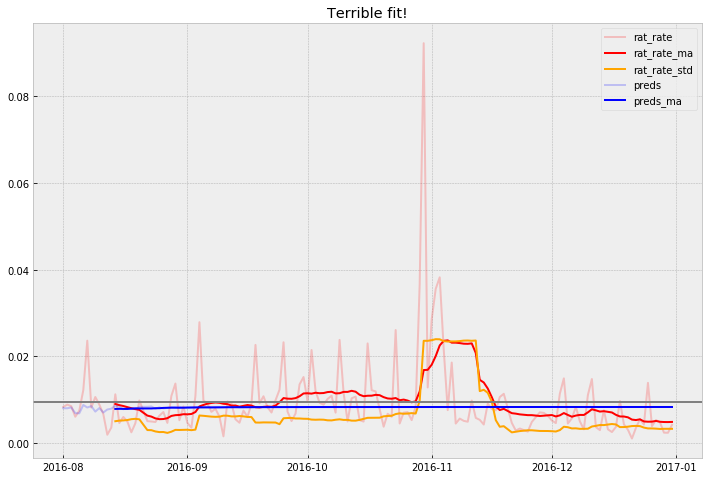

In [209]:
plt.plot(days_p['date'], days_p['rat_rate'], alpha=0.2, color='red')
plt.plot(days_p['date'], days_p['rat_rate_ma'], color='red')
plt.plot(days_p['date'], days_p['rat_rate_std'], color='orange')
plt.plot(days_p['date'], days_p['preds'], alpha=0.2, color='blue')
plt.plot(days_p['date'], days_p['preds_ma'], color='blue')
plt.axhline(days_p['rat_rate'].mean(), color='gray')
plt.title('Terrible fit!')
plt.legend()
plt.show()

Some reading on time series models (since it's been a looong time): [Seasonal ARIMA with Python](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/)